# NFL Play-by-Play Analysis
## Author: Nick Colosi
### Data Source: https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016#NFL%20Play%20by%20Play%202009-2018%20(v5).csv

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from progressbar import ProgressBar
from datetime import datetime
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [34]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [3]:
specific_team = 0
team = 'MIA'

df = pd.read_csv('../Data/NFL_PbP.csv')
df = df.drop(df[df.posteam.isna()].index)

if specific_team == 1:
    df = df[df.posteam == team]

/Users/chochimagic/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
def toDateTime(row):
    return datetime.strptime(row['game_date'], '%Y-%M-%d')

def runBinary(row):
    if row['play_type'] == 'run':
        val = 1
    else:
        val = 0
    return val

def passBinary(row):
    if row['play_type'] == 'pass':
        val = 1
    else:
        val = 0
    return val

In [25]:
df['run'] = df.apply(runBinary, axis = 1)
df['pass'] = df.apply(passBinary, axis = 1)
df['year'] = df['game_date'].dt.year
df['game_date'] = df.apply(toDateTime, axis=1)

In [26]:
# Create new variables based on previous play results 
pbar = ProgressBar()
df['Rush_att'] = 0
df['Pass_att'] = 0
games = df['game_id'].unique()
for game in pbar(games):
    teams = df[df['game_id'] == game]['posteam'].unique()
    for team in teams:
        plays = df[(df['game_id'] == game) & (df['posteam'] == team)].index.values
        for i in range(len(plays)):
            try:
                df.at[plays[i], 'Lag1_run'] = df.at[plays[i - 1], 'run']
                df.at[plays[i], 'Lag2_run'] = df.at[plays[i - 2], 'run']
                df.at[plays[i], 'Lag3_run'] = df.at[plays[i - 3], 'run']
                df.at[plays[i], 'Lag1_yg'] = df.at[plays[i - 1], 'yards_gained']
                
            except:
                df.at[plays[i], 'Lag1_run'] = 'NaN'
                df.at[plays[i], 'Lag2_run'] = 'NaN'
                df.at[plays[i], 'Lag3_run'] = 'NaN'
                df.at[plays[i], 'Lag1_yg'] = 'NaN'
            try:
                df.at[plays[i], 'Rush_att'] = df.at[plays[i - 1], 'Rush_att'] + df.at[plays[i - 1], 'run']
                df.at[plays[i], 'Pass_att'] = df.at[plays[i - 1], 'Pass_att'] + df.at[plays[i - 1], 'pass']
            except:
                pass

100% |########################################################################|


# Red Zone Analysis

In [ ]:
df['redzone'] = df['yardline_100'] <= 20
rz = df[df.redzone == True]
rz = rz[(rz['play_type'] == 'run')|(rz['play_type'] == 'pass') | (rz['play_type'] == 'field_goal')]
rz['pos_sd'] = rz['posteam_score'] - rz['defteam_score']

In [35]:
# Play Type
pd.DataFrame(rz.groupby('play_type')['play_id'].count())/len(rz)

,play_id
play_type,
field_goal,0.103322
pass,0.483648
run,0.413030


In [36]:
# Average Yards Gained
pd.DataFrame(rz.groupby('play_type')['yards_gained'].mean())

,yards_gained
play_type,
field_goal,0.000000
pass,3.208634
run,2.722681


In [37]:
# Average touchdown 
pd.DataFrame(rz.groupby('play_type')['touchdown'].mean())

,touchdown
play_type,
field_goal,0.000579
pass,0.218459
run,0.168366


In [38]:
down_pt = pd.DataFrame(rz.groupby(['down', 'play_type'])['play_id'].count())
down_pt = down_pt.reset_index()
down_pt

,down,play_type,play_id
0,1.0,field_goal,104
1,1.0,pass,7265
2,1.0,run,10530
3,2.0,field_goal,95
4,2.0,pass,8167
5,2.0,run,6781
6,3.0,field_goal,100
7,3.0,pass,7598
8,3.0,run,2669
9,4.0,field_goal,4879


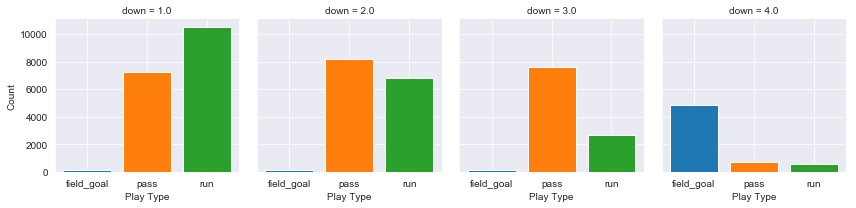

In [45]:
sns.set_style('darkgrid')
ax = sns.FacetGrid(down_pt, col='down', hue = 'play_type')
ax.map(plt.bar, 'play_type', 'play_id').set_axis_labels("Play Type", "Count")

### Modeling

In [46]:
rz_mod = rz[['run', 'pos_sd', 'qtr', 'quarter_seconds_remaining', 'down', 'posteam_timeouts_remaining', 'yardline_100', 'drive', 'ydstogo', 'ydsnet', 'Lag1_run', 'Lag1_yg', 'Pass_att', 'Rush_att']].dropna(axis = 0)

In [47]:
X = rz_mod.drop('run', axis = 1)
y = rz_mod.run

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=2)

In [49]:
lr = LogisticRegression(penalty = 'l2')
dt = DecisionTreeClassifier(min_samples_leaf = 10)
rf = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 50)
gb = GaussianNB()
ada = AdaBoostClassifier(n_estimators = 500)

In [50]:
baseline = [('Logistic Regression', lr), ('Decision Tree', dt), ('Random Forest', rf), ('Naive Bayes', gb), ('Ada Boost', ada)]

/Users/chochimagic/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression
[[6587 2050]
 [2191 3999]]
Decision Tree
[[6516 2121]
 [2427 3763]]
Random Forest
[[6563 2074]
 [1687 4503]]
Naive Bayes
[[6555 2082]
 [2521 3669]]
Ada Boost
[[6714 1923]
 [2053 4137]]


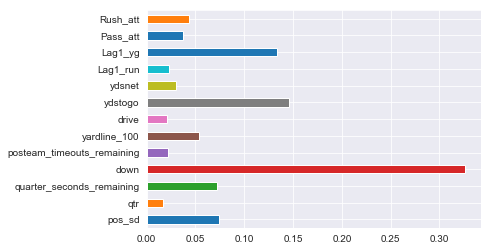

In [51]:
names = []
accuracy = []
auc = []
for name, model in baseline:
    y_pred = []
    names.append(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy.append(model.score(X_test, y_test))
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    auc.append(metrics.auc(fpr, tpr))
    
    print(name)
    print(confusion_matrix(y_test, y_pred))
    if name == 'Random Forest':
        feat_importances = pd.Series(model.feature_importances_, index=X.columns)
        feat_importances.plot(kind='barh')

In [52]:
resB = pd.DataFrame()
resB['Names'] = names
resB['Accuracy'] = accuracy
resB['AUC'] = auc
resB

,Names,Accuracy,AUC
0,Logistic Regression,0.713968,0.704346
1,Decision Tree,0.693262,0.681172
2,Random Forest,0.746341,0.743667
3,Naive Bayes,0.689553,0.675837
4,Ada Boost,0.731841,0.722845
